In [1]:
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statistics as stats
from bson.json_util import dumps, loads
from time import time

client = MongoClient("localhost", 27010)
db = client.research
db.authenticate("marilu", "topsecretpasswordformarilusmongo")
db.collection_names()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: collection_names is deprecated. Use list_collection_names instead.
  if sys.path[0] == '':


['labelled_authors',
 'july2021_all',
 'political_leaning_07_2021',
 'tmpDlTvc.renameCollection',
 'final_db']

In [2]:
t = time()
final_db = list(db.final_db.find())
df = pd.DataFrame(final_db)
df = df.where(pd.notnull(df), None)
print('It took', round((time()-t)/60, 2), 'minutes')

It took 2.68 minutes


In [3]:
print('df shape:', str(df.shape))
#print(str(df.columns))
df.head()

df shape: (5173318, 24)


,_id,age_source_post,author_id,birth_year,created_on,female,gender_source_post,male,nationality,nationality_in_domain,...,personality_intuitive,personality_judging,personality_perceiving,personality_sensing,personality_thinking,political_leaning,political_leaning_in_domain,post_body,post_id,subreddit
0,6435b8e53b94888a0cc624c2,None,t2_4gomk5c3,None,2022-06-02 00:51:00,None,None,None,None,None,...,None,None,None,None,None,center,1,The cringe cookies,iauf7ch,r/PoliticalCompassMemes
1,6435b8e53b94888a0cc624c3,None,t2_4gomk5c3,None,2022-06-03 20:25:06,None,None,None,None,None,...,None,None,None,None,None,center,0,Incoming call from robtop 😳,ib2ddob,r/geometrydash
2,6435b8e53b94888a0cc624c4,None,t2_4gomk5c3,None,2022-06-16 20:51:08,None,None,None,None,None,...,None,None,None,None,None,center,0,Damn what texture pack is this??,icm5atj,r/geometrydash
3,6435b8e53b94888a0cc624c5,None,t2_4gomk5c3,None,2022-06-21 22:50:27,None,None,None,None,None,...,None,None,None,None,None,center,0,r/nextfuckinglevel,id841md,u/DaBabyOnReddit
4,6435b8e53b94888a0cc624c6,None,t2_92exx7h,None,2022-06-01 10:31:27,None,None,None,None,None,...,None,None,None,None,None,center,1,Lauri Törni moment,iarj37e,r/PoliticalCompassMemes


In [4]:
binary_vars = {'gender':{'male': 'male', 'female': 'female'}, 
               'personality_D1':{'extroversion': 'personality_extrovert', 'introversion': 'personality_introvert'},
               'personality_D2': {'sensors': 'personality_sensing', 'intuitives': 'personality_intuitive'},
               'personality_D3':{'thinkers': 'personality_thinking', 'feelers': 'personality_feeling'},
               'personality_D4':{'judgers': 'personality_judging', 'perceivers': 'personality_perceiving'}
              }

categorical_variables = ['nationality', 'political_leaning', 'birth_year']

n_posts_per_label = {'gender':{'male': None, 'female': None},
                     'personality_D1':{'extroversion': None, 'introversion': None},
                     'personality_D2':{'sensors': None, 'intuitives': None},
                     'personality_D3':{'thinkers': None, 'feelers': None},
                     'personality_D4':{'judgers': None, 'perceivers': None},
                     'political_leaning': {},
                     'nationality': {},
                     'birth_year': {}
                    }

percentage_posts_per_label = {'gender':[{'male': None, 'female': None}, None, None],
                              'personality_D1':[{'extroversion': None, 'introversion': None}, None, None],
                              'personality_D2':[{'sensors': None, 'intuitives': None}, None, None],
                              'personality_D3':[{'thinkers': None, 'feelers': None}, None, None],
                              'personality_D4':[{'judgers': None, 'perceivers': None}, None, None],
                              'political_leaning': [{}, None, None],
                              'nationality': [{}, None, None],
                              'birth_year': [{}, None, None]
                             }

In [5]:
# count number of posts per label (binary variables)
for attribute in binary_vars.keys():
    for label in binary_vars[attribute].keys():
        n_posts_per_label[attribute][label] = df[binary_vars[attribute][label]].sum()

In [6]:
# count number of posts per label (categorical variables)
for var in categorical_variables:
    labels = df[var].unique()
    labels = [x for x in labels if x is not None]
    if var == 'birth_year':
        labels = sorted([int(x) for x in labels])
    for label in labels:
        n_posts_per_label[var][str(label)] = df[var].value_counts()[str(label)]


In [7]:
n_posts_per_label['nationality'] = dict(sorted(n_posts_per_label['nationality'].items(),
                                               key=lambda x:x[1], reverse = True))

In [8]:
for attribute in n_posts_per_label.keys():
    tot = 0
    for label in n_posts_per_label[attribute]:
        tot+= n_posts_per_label[attribute][label]
    for label in n_posts_per_label[attribute]:
        percentage_posts_per_label[attribute][0][label] = round((n_posts_per_label[attribute][label]/tot)*100, 2)
        percentage_posts_per_label[attribute][1] = round(tot)
        percentage_posts_per_label[attribute][2] = round((tot/len(df))*100, 2)

In [9]:
percentage_posts_per_label['birth_year'][0] = dict(sorted(percentage_posts_per_label['birth_year'][0].items(),
                                               key=lambda x:x[1], reverse = True))

In [10]:
# each attribute lists contain percentage of specific labels in the attribute's total posts, 
#number of posts of that attribute, percentage occupied by that attribute in the df (NB. personality is 5% in total)
#percentage_posts_per_label

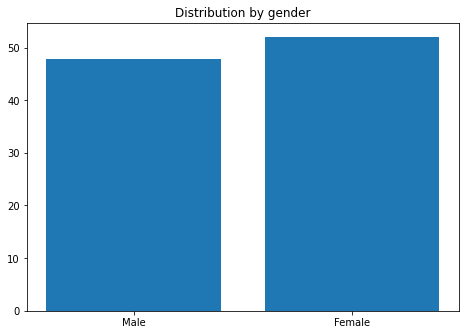

In [11]:
# plot gender
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
gender = ['Male', 'Female']
proportions = [percentage_posts_per_label['gender'][0]['male'], percentage_posts_per_label['gender'][0]['female']]
ax.bar(gender,proportions)
ax.set_title('Distribution by gender')
plt.show()

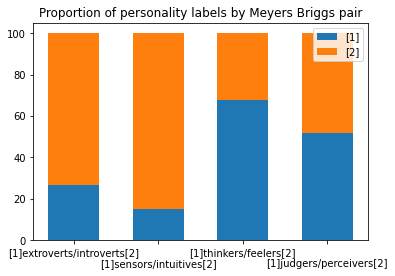

In [12]:
# plot personality
attributes = ('[1]extroverts/introverts[2]', '\n[1]sensors/intuitives[2]', '[1]thinkers/feelers[2]', '\n[1]judgers/perceivers[2]')
label_counts = {
    '[1]': np.array([percentage_posts_per_label['personality_D1'][0]['extroversion'], 
                    percentage_posts_per_label['personality_D2'][0]['sensors'],
                    percentage_posts_per_label['personality_D3'][0]['thinkers'],
                    percentage_posts_per_label['personality_D4'][0]['judgers']]),
    '[2]': np.array([percentage_posts_per_label['personality_D1'][0]['introversion'], 
                    percentage_posts_per_label['personality_D2'][0]['intuitives'],
                    percentage_posts_per_label['personality_D3'][0]['feelers'],
                    percentage_posts_per_label['personality_D4'][0]['perceivers']]),
}
width = 0.6  # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()
bottom = np.zeros(4)

for label, label_counts in label_counts.items():
    p = ax.bar(attributes, label_counts, width, label=label, bottom=bottom)
    bottom += label_counts

    #ax.bar_label(p, label_type='center')

ax.set_title('Proportion of personality labels by Meyers Briggs pair')
ax.legend()

plt.show()

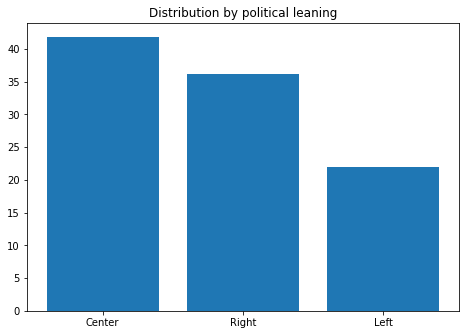

In [13]:
# plot political leaning
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
gender = ['Center', 'Right', 'Left']
proportions = [percentage_posts_per_label['political_leaning'][0]['center'], 
               percentage_posts_per_label['political_leaning'][0]['right'],
              percentage_posts_per_label['political_leaning'][0]['left']]
ax.bar(gender,proportions)
ax.set_title('Distribution by political leaning')
plt.show()

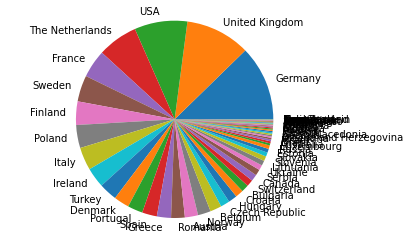

In [14]:
# Plot nationalities
labels = []
sizes = []

for x, y in n_posts_per_label['nationality'].items():
    labels.append(x)
    sizes.append(y)

# Plot
plt.pie(sizes, labels=labels, radius = 10)

plt.axis('equal')
plt.show()

In [15]:
#df['birth_year'].astype('int', errors='ignore')[5173304].describe()
birth_year = [int(x) for x in list(df['birth_year']) if x is not None]
pd.DataFrame({'col':birth_year})['col'].describe()

count    381056.000000
mean       1989.160165
std          12.343291
min        1922.000000
25%        1982.000000
50%        1992.000000
75%        1998.000000
max        2011.000000
Name: col, dtype: float64

<BarContainer object of 70 artists>

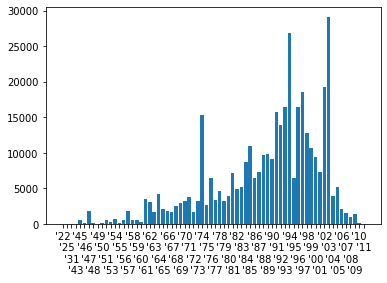

In [16]:
# Plot birth year
birth_year_labels = []
i = 0
for k in n_posts_per_label['birth_year'].keys():
    if i == 4:
        i = 0
    if i == 0:
        space = ''
    birth_year_labels.append(space + '\'' + str(k[2:]))
    space = space + '\n'
    i+=1

plt.bar(birth_year_labels, n_posts_per_label['birth_year'].values())

# Main subreddits by label

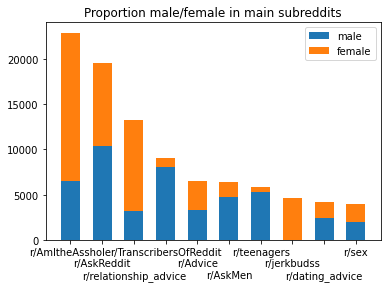

Percentage of posts in the 10 biggest subreddits: 25.25


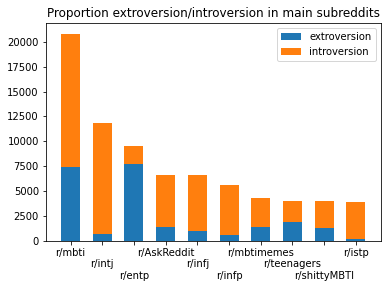

Percentage of posts in the 10 biggest subreddits: 27.5


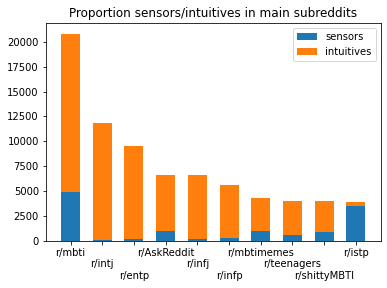

Percentage of posts in the 10 biggest subreddits: 27.5


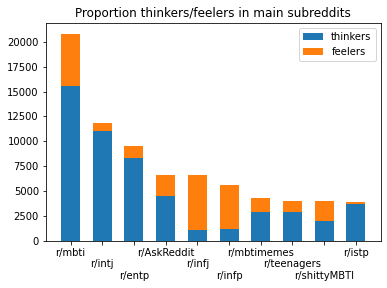

Percentage of posts in the 10 biggest subreddits: 27.5


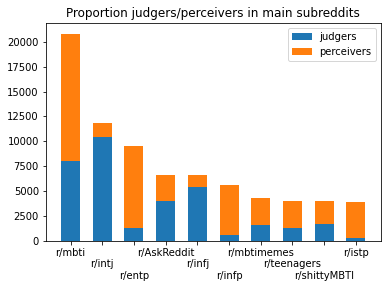

Percentage of posts in the 10 biggest subreddits: 27.5


In [17]:
main_subreddits_byAttribute = {}
for attribute in binary_vars:
    
    x_labels = []
    subreddit_counters = {}
    
    attribute_df = pd.DataFrame(columns = list(df.columns))
    for label in binary_vars[attribute].keys():
        attribute_df = pd.concat([attribute_df, df[(df[binary_vars[attribute][label]] == 1)]])
        subreddit_counters[label] = []
    
    main_subreddits = list(attribute_df['subreddit'].value_counts()[:10].keys())
    
    i = 0
    for subreddit in main_subreddits[:10]:
        if i == 3:
            i = 0
        if i == 0:
            space = ''
        for label in subreddit_counters.keys():
            subreddit_counters[label].append(sum(attribute_df[attribute_df['subreddit'] == subreddit][binary_vars[attribute][label]]==1))
        x_labels.append(space + subreddit)
        space = space + '\n'
        i+=1
    
    width = 0.6  # the width of the bars: can also be len(x) sequence

    fig, ax = plt.subplots()
    bottom = np.zeros(len(main_subreddits))

    for label, label_counts in subreddit_counters.items():
        p = ax.bar(x_labels, label_counts, width, label=label, bottom=bottom)
        bottom += label_counts

    ax.set_title('Proportion {}/{} in main subreddits'.format(list(binary_vars[attribute].keys())[0],
                                                              list(binary_vars[attribute].keys())[1]))
    ax.legend()

    plt.show()
    
    p = round(((sum(subreddit_counters[list(subreddit_counters.keys())[0]]) + sum(subreddit_counters[list(subreddit_counters.keys())[1]]))
               /len(attribute_df))*100,2)
    print('Percentage of posts in the 10 biggest subreddits:', str(p))
   

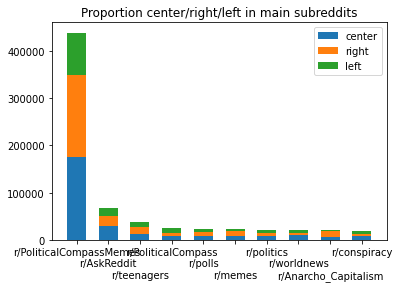

Percentage of posts in the 10 biggest subreddits: 20.76


In [18]:
d = {'political_leaning':{'center':'center','right':'right','left':'left'}}
for attribute in d:
    x_labels = []
    subreddit_counters = {}

    attribute_df = pd.DataFrame(columns = list(df.columns))
    for label in d[attribute].keys():
        attribute_df = pd.concat([attribute_df, df[(df['political_leaning'] == label)]])
        subreddit_counters[label] = []

    main_subreddits = list(attribute_df['subreddit'].value_counts()[:10].keys())

    i = 0
    for subreddit in main_subreddits[:10]:
        if i == 3:
            i = 0
        if i == 0:
            space = ''
        for label in subreddit_counters.keys():
            subreddit_counters[label].append(sum(attribute_df[attribute_df['subreddit'] == subreddit]['political_leaning']==label))
        x_labels.append(space + subreddit)
        space = space + '\n'
        i+=1

    width = 0.6  # the width of the bars: can also be len(x) sequence

    fig, ax = plt.subplots()
    bottom = np.zeros(len(main_subreddits))

    for label, label_counts in subreddit_counters.items():
        p = ax.bar(x_labels, label_counts, width, label=label, bottom=bottom)
        bottom += label_counts

    ax.set_title('Proportion center/right/left in main subreddits')
    ax.legend()

    plt.show()

    p = round(((sum(subreddit_counters['center']) + sum(subreddit_counters['right']) + sum(subreddit_counters['left']))
                   /len(attribute_df))*100,2)
    print('Percentage of posts in the 10 biggest subreddits:', str(p))
 

# Posts length

In [19]:
# posts length
posts_length = []
for post in df['post_body']:
    n = len(post.split())
    posts_length.append(n)

In [20]:
pd.DataFrame({'l':posts_length})['l'].describe()

count    5.173318e+06
mean     3.269285e+01
std      5.428381e+01
min      0.000000e+00
25%      7.000000e+00
50%      1.700000e+01
75%      3.800000e+01
max      2.867000e+03
Name: l, dtype: float64

In [21]:
postsLength_per_label = {'gender':{'male': None, 'female': None},
                         'personality_D1':{'extroversion': None, 'introversion': None},
                         'personality_D2':{'sensors': None, 'intuitives': None},
                         'personality_D3':{'thinkers': None, 'feelers': None},
                         'personality_D4':{'judgers': None, 'perceivers': None},
                         'political_leaning': {},
                         'nationality': {},
                         'birth_year': {}
                        }
postsLength = {}

In [22]:
# count number of posts per label (binary variables)
for attribute in binary_vars.keys():
    postsLength[attribute] = {}
    for label in binary_vars[attribute].keys():
        posts = df.loc[df[binary_vars[attribute][label]] == 1, 'post_body']
        posts_length = []
        for post in posts:
            n = len(post.split())
            posts_length.append(n)
        measures = {}
        measures['mean'] = round(stats.mean(posts_length), 2)
        measures['median'] = round(stats.median(posts_length), 2)
        measures['st.dv'] = round(stats.pstdev(posts_length), 2)
        measures['min'] = min(posts_length)
        measures['max'] = max(posts_length)
        
        postsLength[attribute][label] = posts_length
        postsLength_per_label[attribute][label] = measures

In [23]:
# count number of posts per label (categorical variables)
for attribute in categorical_variables:
    postsLength[attribute] = {}
    labels = df[attribute].unique()
    labels = [x for x in labels if x is not None]
    if attribute == 'birth_year':
        labels = sorted([int(x) for x in labels])
    for label in labels:
        posts = df.loc[df[attribute] == str(label), 'post_body']
        posts_length = []
        for post in posts:
            n = len(post.split())
            posts_length.append(n)
        measures = {}
        measures['mean'] = round(stats.mean(posts_length), 2)
        measures['median'] = round(stats.median(posts_length), 2)
        measures['st.dv'] = round(stats.pstdev(posts_length), 2)
        measures['min'] = min(posts_length)
        measures['max'] = max(posts_length)
        
        postsLength[attribute][label] = posts_length
        postsLength_per_label[attribute][label] = measures
    

In [24]:
#postsLength_per_label

In [25]:
national_abbreviations = {'Spain':'ESP','Ireland':'IRL','Germany':'DEU','Slovenia':'SVN','Denmark':'DNK','Argentina':'ARG',
 'United Kingdom':'GBR','Finland':'FIN','Poland':'POL','France':'FRA','Turkey':'TUR','Italy':'ITA',
 'Sweden':'SWE','Bulgaria':'BGR','Canada':'CAN','USA':'USA','Kazakhstan':'KAZ','The Netherlands':'NLD',
 'Czech Republic':'CZE','Portugal':'PRT','Ukraine':'UKR','Belgium':'BEL','Hungary':'HUN','Norway':'NOR',
 'Serbia':'SRB','Australia':'AUS','Slovakia':'SVK','Israel':'ISR','Switzerland':'CHE','Lithuania':'LTU',
 'Kosovo':'XK','Bosnia and Herzegovina':'BIH','Greece':'GRC','Austria':'AUT','Romania':'ROU','Georgia':'GEO',
 'Albania':'ALB','Montenegro':'MNE','Uruguay':'URY','Croatia':'HRV','Estonia':'EST','Russia':'RUS',
 'Brazil':'BRA','North Macedonia':'MKD','Greenland':'GRL','Iceland':'ISL','Mexico':'MEX','Cyprus':'CYP',
 'Luxembourg':'LUX','Chili':'CHL','Catalonia':'ESP','Malta':'MLT','Kuwait':'KWT','Azerbaijan':'AZE',
 'Armenia':'ARM','Syria':'SYR','Moldova':'MDA','Taiwan':'TWN','Liechtenstein':'LIE','Iran':'IRN',
 'Philippines':'PHL','India':'IND','New Zealand':'NZL','Cuba':'CUB','Japan':'JPN'}


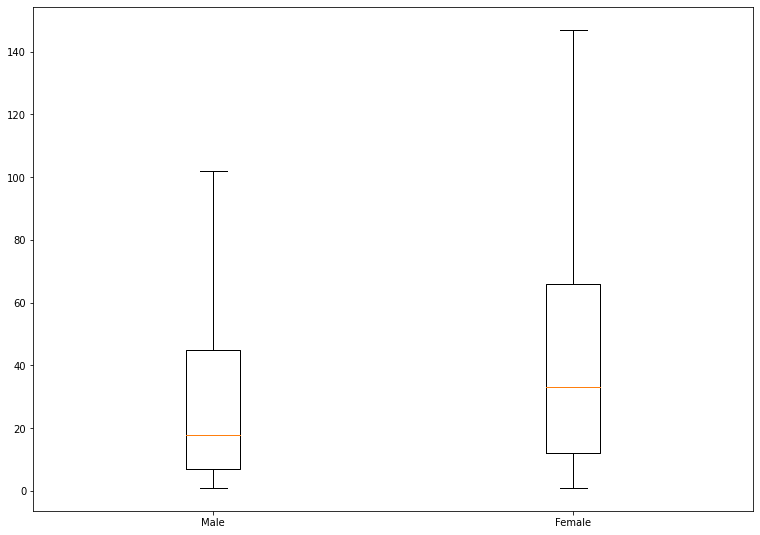

In [26]:
# plot posts length by gender
data = [postsLength['gender']['male'], postsLength['gender']['female']]
fig = plt.figure(figsize =(10, 7))
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
# Creating plot
bp = ax.boxplot(data, showfliers=False)
# show plot
plt.xticks([1, 2], ['Male', 'Female'])
plt.show()


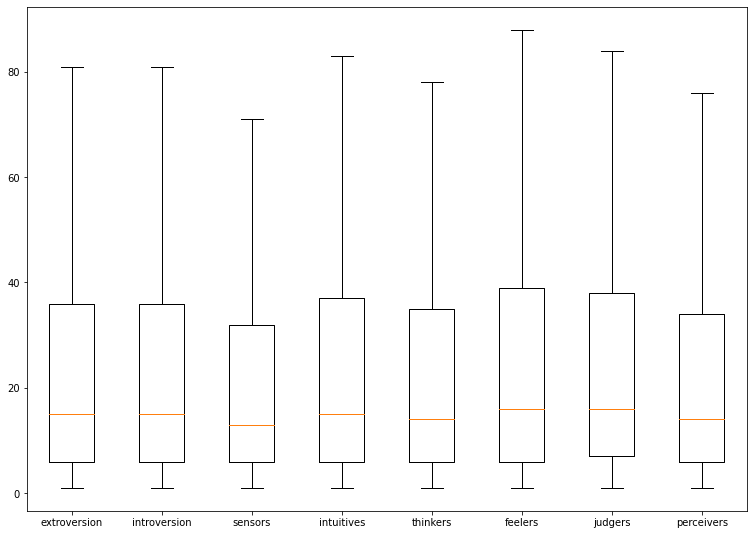

In [27]:
# plot posts length by personality
attributes = ['personality_D1', 'personality_D2', 'personality_D3', 'personality_D4']
data = []
labels = []
for attribute in attributes:
    for label in postsLength[attribute].keys():
        data.append(postsLength[attribute][label])
        labels.append(label)
fig = plt.figure(figsize =(10, 7))
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
# Creating plot
bp = ax.boxplot(data, showfliers=False)
# show plot
plt.xticks(list(range(1,len(labels)+1)), labels)
plt.show()

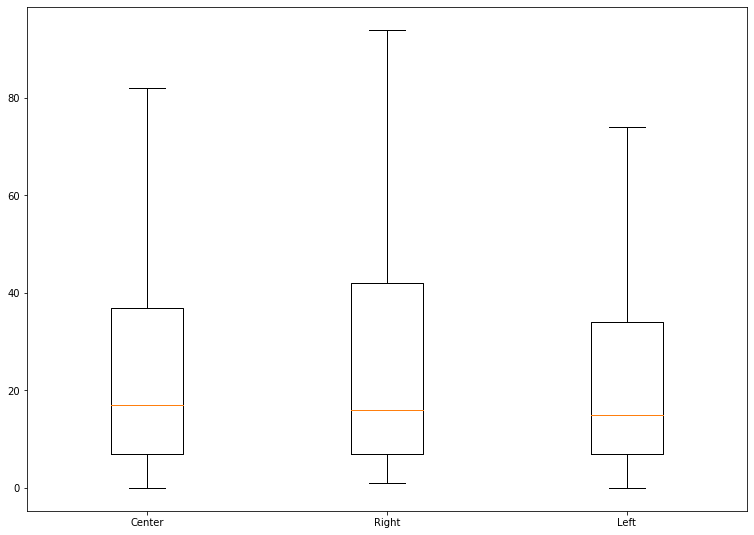

In [28]:
# plot posts length by political leaning
data = [postsLength['political_leaning']['center'], postsLength['political_leaning']['right'], postsLength['political_leaning']['left']]
fig = plt.figure(figsize =(10, 7))
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
# Creating plot
bp = ax.boxplot(data, showfliers=False)
# show plot
plt.xticks([1, 2, 3], ['Center', 'Right', 'Left'])
plt.show()

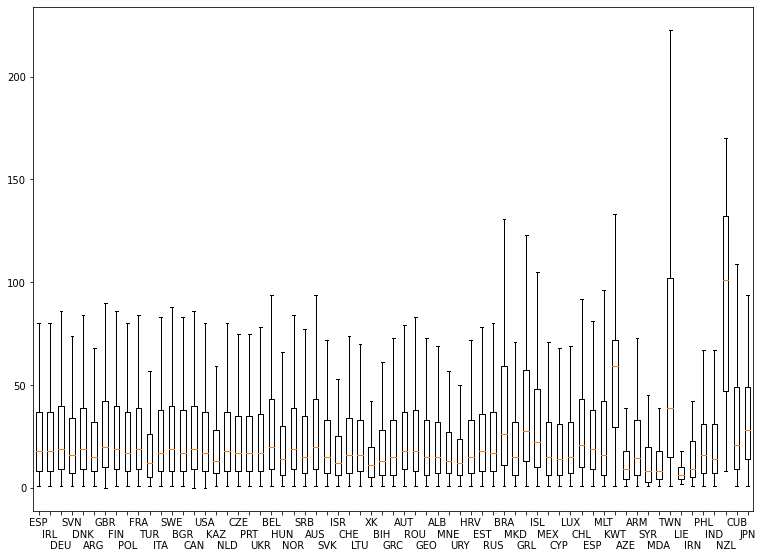

In [29]:
# plot posts length by nationality
attributes = ['nationality']
data = []
labels = []
for attribute in attributes:
    i = 0
    for label in postsLength[attribute].keys():
        if i == 3:
            i = 0
        if i == 0:
            space = ''
        data.append(postsLength[attribute][label])
        labels.append(space + national_abbreviations[label])
        space = space + '\n'
        i+=1
fig = plt.figure(figsize =(10, 7))
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
# Creating plot
bp = ax.boxplot(data, showfliers=False)
# show plot
plt.xticks(list(range(1,len(labels)+1)), labels)
plt.show()

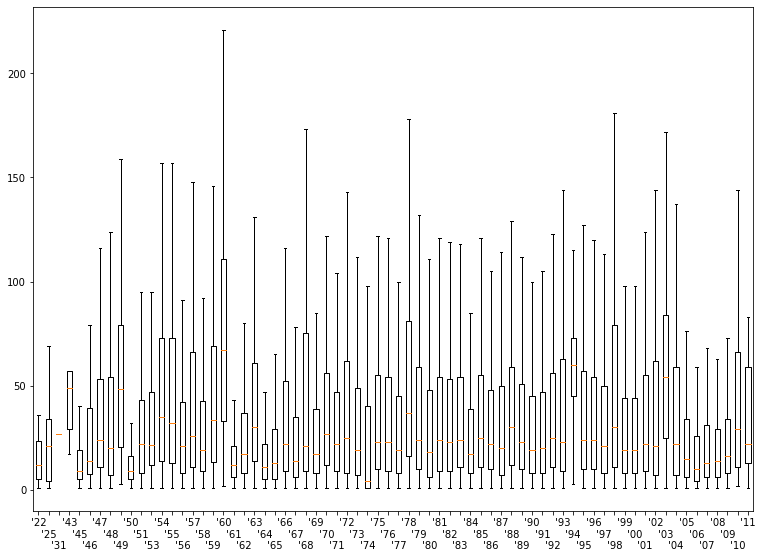

In [30]:
# plot posts length by birth_year
attributes = ['birth_year']
data = []
labels = []
for attribute in attributes:
    i = 0
    for label in postsLength[attribute].keys():
        if i == 3:
            i = 0
        if i == 0:
            space = '\''
        data.append(postsLength[attribute][label])
        labels.append(space + str(label)[2:])
        space = '\n' + space
        i+=1
fig = plt.figure(figsize =(10, 7))
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
# Creating plot
bp = ax.boxplot(data, showfliers=False)
# show plot
plt.xticks(list(range(1,len(labels)+1)), labels)
plt.show()

# Posts - author ratio